# 0.8372 方案

**启发自**：https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210 A5节83.2%，在这基础之上改进：0.5% 

![image.png](http://qmem98ip3.bkt.clouddn.com/gitpages/kaggle/Titanic/1.png)
![image.png](http://qmem98ip3.bkt.clouddn.com/gitpages/kaggle/Titanic/2.png)

**与0.82275方案，主要改进：非男孩的男性不列入"女性男孩组"，即分组之前先将非男孩的男性统一划分为"NoGroup", 然后再按照name Ticket两个特征得到其他特征。**

In [51]:
import pandas as pd #数据分析
import numpy as np #科学计算
import seaborn as sns
import pylab 
import matplotlib.pyplot as plt

%matplotlib inline

sns.set_style("whitegrid") 

In [52]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

all_data = pd.concat([train, test], ignore_index = True)

In [53]:
def getTitleFeature(dataset):
    upper_limit_children = 12
    dataset['Title'] = 'man'
    dataset.loc[dataset.Sex == 'female', 'Title'] = 'woman'
    dataset.loc[dataset.Name.str.contains('Master') | ((dataset.Age <= upper_limit_children) & (dataset.Sex == 'male')), 'Title'] = 'boy'

def getSurnameGroupId(dataset):
    dataset['Surname']=dataset['Name'].apply(lambda x:x.split(',')[0].strip())
    dataset['SurnameGroupId'] = dataset.apply(lambda row : str(row.Surname + '-' + str(row.Pclass) + '-' + str(row.Fare) + '-' + str(row.Embarked) + '-' + row.Ticket[:-2] + '__'), axis = 1)
    
def getSurnameGroupSize(dataset):
    surname_group_id_value_counts = dataset['SurnameGroupId'].value_counts()
    dataset['SurnameGroupSize'] = dataset.SurnameGroupId.apply(lambda x: surname_group_id_value_counts.loc[x])
    
def getTicketGroupId(dataset):
    dataset['TicketGroupId'] = dataset.apply(lambda row : str(str(row.Pclass) + '-' + str(row.Embarked) + '-' + str(row.Fare) + '-' + row.Ticket[:-1] + '_'), axis = 1)

def getSurnameGroupSurvival(dataset, indices_train_set):
    '''
    @dataset: a combination of train set and test set
    @indices_train_set: 
    '''
    dataset['SurnameGroupSurvived'] = np.NaN
    surname_group_survived_mean = dataset.loc[indices_train_set, ['SurnameGroupId', 'Survived']].groupby(['SurnameGroupId']).Survived.mean()
    dataset.loc[indices_train_set, 'SurnameGroupSurvived'] = dataset.loc[indices_train_set, 'SurnameGroupId'].apply(lambda x: surname_group_survived_mean.loc[x])
    
def addNanniesCousinsFriends(dataset, verbose = False):
    # solo women and children
    count = 0
    ##
    indices_solo_woman_child = dataset.loc[(dataset.Title != 'man') & (dataset.SurnameGroupId == 'nogroup')].index
    for idx in indices_solo_woman_child:
        items = dataset.loc[(dataset.TicketGroupId == dataset.loc[idx, 'TicketGroupId']) & (dataset.loc[idx, 'PassengerId'] != dataset.PassengerId), 'SurnameGroupId']
        if items.shape[0] > 0:
            dataset.loc[idx, 'SurnameGroupId'] = items.iloc[0]
        if (dataset.loc[idx,'SurnameGroupId'] != 'nogroup'): #单独出行的两个人，即使是朋友一起出行也不能加在一起
            count += 1
            if verbose:
                print(dataset.loc[idx,'SurnameGroupId'])
    if verbose:
        print('Tootally adding %d nannies, cousins and friends' % count)

## Name feature

In [54]:
all_data['Surname']=all_data['Name'].apply(lambda x:x.split(',')[0].strip())
all_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Surname
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Braund
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Cumings
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Heikkinen
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Futrelle
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Allen


## SurnameGroupId

In [55]:
getSurnameGroupId(all_data)

all_data.drop(['SibSp', 'Parch', 'Survived', 'Name'], axis = 1).head()

,Age,Cabin,Embarked,Fare,PassengerId,Pclass,Sex,Ticket,Surname,SurnameGroupId
0,22.0,NaN,S,7.2500,1,3,male,A/5 21171,Braund,Braund-3-7.25-S-A/5 211__
1,38.0,C85,C,71.2833,2,1,female,PC 17599,Cumings,Cumings-1-71.2833-C-PC 175__
2,26.0,NaN,S,7.9250,3,3,female,STON/O2. 3101282,Heikkinen,Heikkinen-3-7.925-S-STON/O2. 31012__
3,35.0,C123,S,53.1000,4,1,female,113803,Futrelle,Futrelle-1-53.1-S-1138__
4,35.0,NaN,S,8.0500,5,3,male,373450,Allen,Allen-3-8.05-S-3734__


## Title feature

In [56]:
getTitleFeature(all_data)
all_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Surname,SurnameGroupId,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Braund,Braund-3-7.25-S-A/5 211__,man
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Cumings,Cumings-1-71.2833-C-PC 175__,woman
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Heikkinen,Heikkinen-3-7.925-S-STON/O2. 31012__,woman
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Futrelle,Futrelle-1-53.1-S-1138__,woman
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Allen,Allen-3-8.05-S-3734__,man


In [57]:
np.sum(all_data.Title == 'woman'), np.sum(all_data.Title == 'boy'), np.sum(all_data.Title == 'man')

(466, 62, 781)

## Don't group men

**重点**：男人不进行分组

In [58]:
men = all_data.loc[all_data.Title == 'man']
all_data.loc[all_data.Title == 'man', 'SurnameGroupId'] = 'nogroup'

## SurnameGroupSize

In [59]:
getSurnameGroupSize(all_data)
all_data.drop(['SibSp', 'Parch', 'Survived', 'Name'], axis = 1).head()

,Age,Cabin,Embarked,Fare,PassengerId,Pclass,Sex,Ticket,Surname,SurnameGroupId,Title,SurnameGroupSize
0,22.0,NaN,S,7.2500,1,3,male,A/5 21171,Braund,nogroup,man,781
1,38.0,C85,C,71.2833,2,1,female,PC 17599,Cumings,Cumings-1-71.2833-C-PC 175__,woman,1
2,26.0,NaN,S,7.9250,3,3,female,STON/O2. 3101282,Heikkinen,Heikkinen-3-7.925-S-STON/O2. 31012__,woman,1
3,35.0,C123,S,53.1000,4,1,female,113803,Futrelle,Futrelle-1-53.1-S-1138__,woman,1
4,35.0,NaN,S,8.0500,5,3,male,373450,Allen,nogroup,man,781


## Don't group solo passengers

**重点：** 单独出行的人不进行分组

In [60]:
all_data.loc[all_data.SurnameGroupSize == 1, 'SurnameGroupId'] = 'nogroup'
all_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Surname,SurnameGroupId,Title,SurnameGroupSize
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Braund,nogroup,man,781
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Cumings,nogroup,woman,1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Heikkinen,nogroup,woman,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Futrelle,nogroup,woman,1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Allen,nogroup,man,781


In [61]:
all_data.loc[all_data.SurnameGroupSize == 1].shape

(307, 16)

## TicketGroupId

In [62]:
getTicketGroupId(all_data)
                                           
all_data.drop(['SibSp', 'Parch', 'Survived', 'Name'], axis = 1).head()                   

,Age,Cabin,Embarked,Fare,PassengerId,Pclass,Sex,Ticket,Surname,SurnameGroupId,Title,SurnameGroupSize,TicketGroupId
0,22.0,NaN,S,7.2500,1,3,male,A/5 21171,Braund,nogroup,man,781,3-S-7.25-A/5 2117_
1,38.0,C85,C,71.2833,2,1,female,PC 17599,Cumings,nogroup,woman,1,1-C-71.2833-PC 1759_
2,26.0,NaN,S,7.9250,3,3,female,STON/O2. 3101282,Heikkinen,nogroup,woman,1,3-S-7.925-STON/O2. 310128_
3,35.0,C123,S,53.1000,4,1,female,113803,Futrelle,nogroup,woman,1,1-S-53.1-11380_
4,35.0,NaN,S,8.0500,5,3,male,373450,Allen,nogroup,man,781,3-S-8.05-37345_


## add nannies friends and cousins

In [63]:
addNanniesCousinsFriends(all_data, verbose = True)

Spedden-1-134.5-C-169__
Allison-1-151.55-S-1137__
Ryerson-1-262.375-C-PC 176__
Allison-1-151.55-S-1137__
Zabour-3-14.4542-C-26__
Panula-3-39.6875-S-31012__
Spedden-1-134.5-C-169__
Ryerson-1-262.375-C-PC 176__
Wick-1-164.8667-S-369__
Tootally adding 9 nannies, cousins and friends


## resize SurnameGroupSize

In [64]:
getSurnameGroupSize(all_data)

## men in women-children groups

In [65]:
print("There were %d passengers outside the groups of women-children" % all_data.loc[all_data.SurnameGroupId == 'nogroup'].shape[0])

There were 1079 passengers outside the groups of women-children


In [66]:
print("There were %d groups of women-children" % all_data.loc[all_data.SurnameGroupId != 'nogroup'].SurnameGroupId.unique().shape[0])

There were 81 groups of women-children


In [67]:
count_man_in_wcg = 0
men_in_wcg = []
for surname_group_id in men.SurnameGroupId:
    if all_data.loc[all_data.SurnameGroupId == surname_group_id].shape[0] > 0:
        count_man_in_wcg += 1
        men_in_wcg.append(surname_group_id)
print("There were %d mens in women-children groups" % count_man_in_wcg)

There were 51 mens in women-children groups


In [68]:
survived_men_wcg = men.loc[men.SurnameGroupId.isin(men_in_wcg) & (men.Survived == 1)]
survived_men_wcg

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Surname,SurnameGroupId,Title
301,NaN,NaN,Q,23.2500,"McCoy, Mr. Bernard",0,302,3,male,2,1.0,367226,McCoy,McCoy-3-23.25-Q-3672__,man
390,36.0,B96 B98,S,120.0000,"Carter, Mr. William Ernest",2,391,1,male,1,1.0,113760,Carter,Carter-1-120.0-S-1137__,man
622,20.0,NaN,C,15.7417,"Nakid, Mr. Sahid",1,623,3,male,1,1.0,2653,Nakid,Nakid-3-15.7417-C-26__,man


In [69]:
tmp = all_data.loc[all_data.SurnameGroupId.isin(survived_men_wcg.SurnameGroupId)].groupby(['SurnameGroupId']).Survived.mean().value_counts()
tmp 

1.0    3
Name: Survived, dtype: int64

In [70]:
perished_men_wcg = men.loc[men.SurnameGroupId.isin(men_in_wcg) & (men.Survived == 0)]
perished_men_wcg.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Surname,SurnameGroupId,Title
13,39.0,NaN,S,31.275,"Andersson, Mr. Anders Johan",5,14,3,male,1,0.0,347082,Andersson,Andersson-3-31.275-S-3470__,man
27,19.0,C23 C25 C27,S,263.000,"Fortune, Mr. Charles Alexander",2,28,1,male,3,0.0,19950,Fortune,Fortune-1-263.0-S-199__,man
86,16.0,NaN,S,34.375,"Ford, Mr. William Neal",3,87,3,male,1,0.0,W./C. 6608,Ford,Ford-3-34.375-S-W./C. 66__,man
93,26.0,NaN,S,20.575,"Dean, Mr. Bertram Frank",2,94,3,male,1,0.0,C.A. 2315,Dean,Dean-3-20.575-S-C.A. 23__,man
148,36.5,F2,S,26.000,"Navratil, Mr. Michel (""Louis M Hoffman"")",2,149,2,male,0,0.0,230080,Navratil,Navratil-2-26.0-S-2300__,man


In [71]:
tmp = all_data.loc[all_data.SurnameGroupId.isin(perished_men_wcg.SurnameGroupId)].groupby(['SurnameGroupId']).Survived.mean().value_counts()
tmp

1.0    14
0.0    13
Name: Survived, dtype: int64

## all perished group

In [72]:
groups = all_data.loc[all_data.SurnameGroupId != 'nogroup'].groupby(['SurnameGroupId'])

all_perished_groups = pd.DataFrame()
one_more_survived_groups = pd.DataFrame()

for index, group in groups:
    indices = group.Survived.value_counts().index
    if indices.shape[0] == 0:
        all_perished_groups = all_perished_groups.append(group)
    else:
        one_more_survived_groups = one_more_survived_groups.append(group)
        
groups = None

In [73]:
all_perished_groups.drop(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'SibSp', 'Pclass', 'Ticket', "PassengerId"], axis = 1)

,Sex,Survived,Surname,SurnameGroupId,Title,SurnameGroupSize,TicketGroupId
1259,female,NaN,Gibson,Gibson-1-59.4-C-1123__,woman,2,1-C-59.4-11237_
1293,female,NaN,Gibson,Gibson-1-59.4-C-1123__,woman,2,1-C-59.4-11237_
1044,female,NaN,Klasen,Klasen-3-12.1833-S-3504__,woman,2,3-S-12.1833-35040_
1154,female,NaN,Klasen,Klasen-3-12.1833-S-3504__,woman,2,3-S-12.1833-35040_
1050,female,NaN,Peacock,Peacock-3-13.775-S-SOTON/O.Q. 31013__,woman,3,3-S-13.775-SOTON/O.Q. 310131_
1172,male,NaN,Peacock,Peacock-3-13.775-S-SOTON/O.Q. 31013__,boy,3,3-S-13.775-SOTON/O.Q. 310131_
1300,female,NaN,Peacock,Peacock-3-13.775-S-SOTON/O.Q. 31013__,woman,3,3-S-13.775-SOTON/O.Q. 310131_
1083,male,NaN,van Billiard,van Billiard-3-14.5-S-A/5. 8__,boy,2,3-S-14.5-A/5. 85_
1235,male,NaN,van Billiard,van Billiard-3-14.5-S-A/5. 8__,boy,2,3-S-14.5-A/5. 85_


如何确定这些全部遇难组的情况呢？，来看看一下数据：

In [74]:
one_more_survived_groups.shape[0]

221

### Pclass

Pclass
1    0.920000
2    1.000000
3    0.364583
Name: Survived, dtype: float64


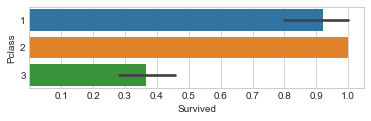

In [75]:
pylab.rcParams['figure.figsize'] = (6.0, 1.5) 
plt.xticks(ticks=np.linspace(0.1, 1.0, 10))
print(one_more_survived_groups.loc[one_more_survived_groups.Survived.notna()].groupby(['Pclass']).Survived.mean())
sns.barplot(x= 'Survived', y= 'Pclass', data=one_more_survived_groups.loc[one_more_survived_groups.Survived.notna()], orient='h')

### Sex

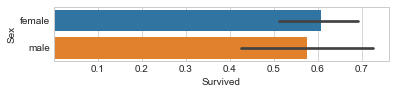

In [76]:
pylab.rcParams['figure.figsize'] = (6.0, 1.0) 
plt.xticks(ticks=np.linspace(0.1, 1.0, 10))
sns.barplot(x= 'Survived', y= 'Sex', data=one_more_survived_groups.loc[one_more_survived_groups.Survived.notna()], orient='h')

### Age

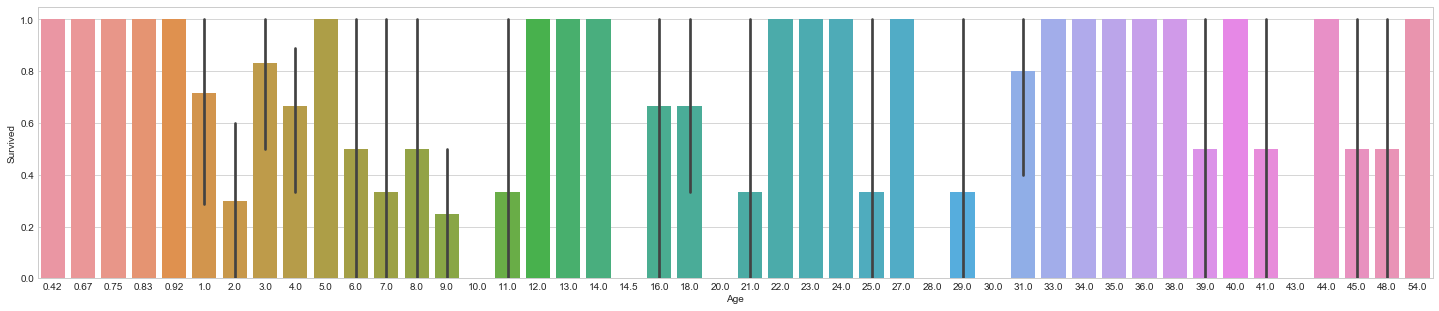

In [77]:
pylab.rcParams['figure.figsize'] = (25.0, 5.0) 
sns.barplot(x= 'Age', y= 'Survived', data=one_more_survived_groups.loc[one_more_survived_groups.Survived.notna()], orient='v')

In [78]:
def getAgeSegment(age):
    age_seg = 5
    if age < 15:
        age_seg = 1 # aldolescents
    elif age <= 32 :
        age_seg = 2
    elif age <= 60 : # almost retirement age
        age_seg = 3
    return age_seg

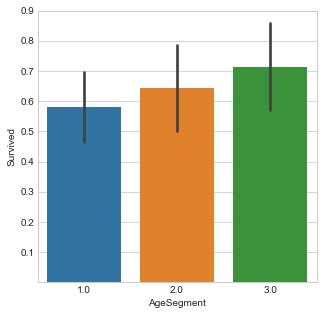

In [79]:
one_more_survived_groups['AgeSegment'] = np.NaN
one_more_survived_groups['AgeSegment'] = one_more_survived_groups.Age.apply(lambda x: x if np.isnan(x) else getAgeSegment(x))
pylab.rcParams['figure.figsize'] = (5.0, 5.0) 
plt.yticks(ticks=np.linspace(0.1, 1.0, 10))
sns.barplot(x= 'AgeSegment', y= 'Survived', data=one_more_survived_groups.loc[one_more_survived_groups.Survived.notna() & one_more_survived_groups.Age.notna()])

### Embarked

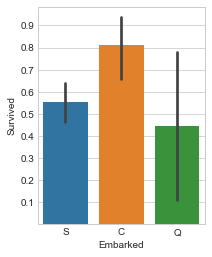

In [80]:
pylab.rcParams['figure.figsize'] = (3.0, 4.0) 
plt.yticks(ticks=np.linspace(0.1, 1.0, 10))
sns.barplot(x= 'Embarked', y= 'Survived', data=one_more_survived_groups.loc[one_more_survived_groups.Survived.notna()], orient='v')

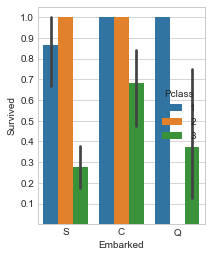

In [81]:
plt.yticks(ticks=np.linspace(0.1, 1.0, 10))
sns.barplot(x= 'Embarked', y= 'Survived', hue='Pclass' ,data=one_more_survived_groups.loc[one_more_survived_groups.Survived.notna()], orient='v')

### Cabin

In [82]:
one_more_survived_groups.Cabin = one_more_survived_groups.Cabin.fillna('Unknown')
one_more_survived_groups.Cabin.apply(lambda x: str(x)[0]).head(10)

279     U
1283    U
855     U
1198    U
297     C
305     C
498     C
708     U
1032    U
119     U
Name: Cabin, dtype: object

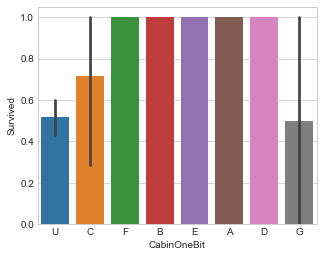

In [83]:
one_more_survived_groups['CabinOneBit'] = one_more_survived_groups.Cabin.apply(lambda x: str(x)[0])
pylab.rcParams['figure.figsize'] = (5.0, 4.0) 
sns.barplot(x= 'CabinOneBit', y= 'Survived', data=one_more_survived_groups.loc[one_more_survived_groups.Survived.notna()], orient='v')

### Fare

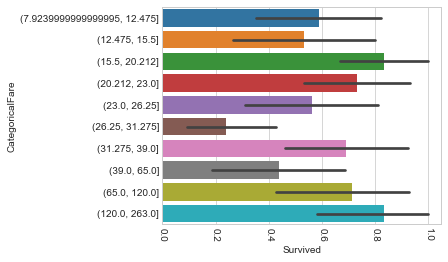

In [84]:
one_more_survived_groups['CategoricalFare'] = pd.qcut(one_more_survived_groups['Fare'], 10)
fare_survived = one_more_survived_groups.loc[:,['CategoricalFare', 'Survived']].groupby(['CategoricalFare']).mean()
plt.xticks(rotation=270)
plt.yticks(ticks=np.linspace(0.1, 1.0, 10))
pylab.rcParams['figure.figsize'] =(5, 5)
sns.barplot(x='Survived', y='CategoricalFare', data=one_more_survived_groups, orient='h')
#one_more_survived_groups.drop(['CategoricalFare'], axis = 1, inplace=True)

## Cross Validation

In [85]:
def custom_cv(train_set, num_fold = 5, verbose = False, num_trial = 5):
    k = num_fold
    sum_accuracy_all_trial = 0.0
    size_test_set_in_cv = train_set.shape[0] // num_fold
    
    getTitleFeature(train_set)
    
    ## engineering the woman-child-group ##
    
    # SurnameGroupId
    getSurnameGroupId(train_set)
    train_set.loc[train_set.Title == 'man', 'SurnameGroupId'] = 'nogroup'
    
    # SurnameGroupSize
    getSurnameGroupSize(train_set)
    train_set.loc[train_set.SurnameGroupSize == 1, 'SurnameGroupId'] = 'nogroup'
    
    ## add nannies cousins friends ##
    
    # TicketGroupId
    getTicketGroupId(train_set)
    addNanniesCousinsFriends(train_set, verbose=True)
    
    #resize SurnameGroupSize
    surname_group_id_value_counts = train_set['SurnameGroupId'].value_counts()
    train_set['SurnameGroupSize'] = train_set.SurnameGroupId.apply(lambda x: surname_group_id_value_counts.loc[x])

    for i in range(0, num_trial):
        sum_accuracy_per_trial = 0.0
        all_set_in_cv = train_set.sample(n = train.shape[0], random_state= i)
        for j in range(0, k):
            # get indices of test set and train set in cross validation
            start_index = j * size_test_set_in_cv
            indices_test_set_in_cv = np.linspace(0, size_test_set_in_cv - 1, num = size_test_set_in_cv, dtype = np.int32) + start_index
            indices_train_set_in_cv = all_set_in_cv.drop(labels=indices_test_set_in_cv).index

            # get SurnameGroupSurvived in train set 
            getSurnameGroupSurvival(all_set_in_cv, indices_train_set_in_cv)

            # set SurnameGroupSurvived in test set
            for idx in indices_test_set_in_cv:
                tmp = all_set_in_cv.loc[(all_set_in_cv.SurnameGroupId == all_set_in_cv.loc[idx,['SurnameGroupId']].values[0]) & (all_set_in_cv.SurnameGroupSurvived.notna()), ['SurnameGroupSurvived']]
                if tmp.shape[0] > 0:
                    all_set_in_cv.loc[idx, ['SurnameGroupSurvived']] = tmp.values[0]
                if (pd.isna(all_set_in_cv.loc[idx, ['SurnameGroupSurvived']].values)): # unknown woman-child-group
                    if all_set_in_cv.loc[idx, ['Pclass']].values == 3:
                        all_set_in_cv.loc[idx, ['SurnameGroupSurvived']] = 0
                    else:
                        all_set_in_cv.loc[idx, ['SurnameGroupSurvived']] = 1
            # female and boy rules
            all_set_in_cv['Predict'] = 0.0
            all_set_in_cv.loc[all_set_in_cv.Title == 'woman', ['Predict']] = 1.0
            all_set_in_cv.loc[(all_set_in_cv.SurnameGroupSurvived == 1) & (all_set_in_cv.Title == 'boy'), ['Predict']] = 1.0
            all_set_in_cv.loc[(all_set_in_cv.SurnameGroupSurvived == 0) & (all_set_in_cv.Title == 'woman'), ['Predict']] = 0.0
            accuracy_per_time = np.sum(all_set_in_cv.iloc[indices_test_set_in_cv, :].Predict.astype(np.int32).values == all_set_in_cv.iloc[indices_test_set_in_cv, :].Survived.astype(np.int32).values) / size_test_set_in_cv
            sum_accuracy_per_trial += accuracy_per_time  

        sum_accuracy_per_trial = sum_accuracy_per_trial / num_fold
        sum_accuracy_all_trial += sum_accuracy_per_trial
        if verbose == True:
            print("Trial %d has %d-fold CV accuracy = %f" % (i + 1, num_fold, sum_accuracy_per_trial)) 
    print('Average accuracy in total %d times trials = %f' % (num_trial, sum_accuracy_all_trial / num_trial)) 

In [86]:
custom_cv(train, num_fold=10, verbose=True, num_trial=10)

Allison-1-151.55-S-1137__
Tootally adding 1 nannies, cousins and friends
Trial 1 has 10-fold CV accuracy = 0.848315
Trial 2 has 10-fold CV accuracy = 0.847191
Trial 3 has 10-fold CV accuracy = 0.846067
Trial 4 has 10-fold CV accuracy = 0.847191
Trial 5 has 10-fold CV accuracy = 0.847191
Trial 6 has 10-fold CV accuracy = 0.847191
Trial 7 has 10-fold CV accuracy = 0.847191
Trial 8 has 10-fold CV accuracy = 0.847191
Trial 9 has 10-fold CV accuracy = 0.847191
Trial 10 has 10-fold CV accuracy = 0.847191
Average accuracy in total 10 times trials = 0.847191


In [87]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Surname',
       'SurnameGroupId', 'SurnameGroupSize', 'TicketGroupId'],
      dtype='object')

## SurnameGroupSurvived

In [88]:
getSurnameGroupSurvival(all_data, train.index)

## Make predictions

In [89]:
unknown_survived_surname_group =[]
count_in_wcg_of_train_set = 0
all_data.loc[train.shape[0]:, 'SurnameGroupSurvived'] = np.NaN

for idx in range(train.shape[0], all_data.shape[0]):
    tmp = all_data.loc[(all_data.SurnameGroupId == all_data.loc[idx, 'SurnameGroupId']), 'SurnameGroupSurvived'].iloc[0]
    if pd.notna(tmp):
        all_data.loc[idx, ['SurnameGroupSurvived']] = tmp
        count_in_wcg_of_train_set += 1
    else:
        print(tmp)
        unknown_survived_surname_group.append(all_data.loc[idx,'SurnameGroupId'])
    if (pd.isna(all_data.loc[idx, ['SurnameGroupSurvived']].values)):
        if all_data.loc[idx, ['Pclass']].values == 3:
            all_data.loc[idx, ['SurnameGroupSurvived']] = 0
        else:
            all_data.loc[idx, ['SurnameGroupSurvived']] = 1

# female and boy rules
all_data['Predict'] = 0.0
all_data.loc[all_data.Title == 'woman', 'Predict'] = 1.0
all_data.loc[(all_data.SurnameGroupSurvived == 1) & (all_data.Title == 'boy'), 'Predict'] = 1.0
all_data.loc[(all_data.SurnameGroupSurvived == 0) & (all_data.Title == 'woman'), 'Predict'] = 0.0

nan
nan
nan
nan


In [90]:
print(count_in_wcg_of_train_set)

414


In [91]:
np.sum(all_data.loc[:train.shape[0], 'Predict'] == all_data.loc[:train.shape[0], 'Survived']) / train.shape[0]

0.8597081930415263

In [92]:
predictions = all_data.loc[train.shape[0]:, 'Predict']
PassengerId = np.array(range(892, 892 + predictions.shape[0]))
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})

In [94]:
submission.to_csv('./data/predictions.csv', index=False)